# **Artificial Neural Network for MNIST Handwritten Digit Classification**

## **Import libraries**

In [3]:
import numpy as np
import os
import pickle
import gzip
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## **Load and explore data**

In [4]:
def read_mnist(mnist_file):
    if os.path.isfile(mnist_file) == False:
        mnist_file = os.path.join(os.path.expanduser('~'), 'data', 'mnist.pkl.gz')
    
    f = gzip.open(mnist_file, 'rb')
    train_data, val_data, test_data = pickle.load(f, encoding='latin1')
    f.close()
    
    train_X, train_Y = train_data
    val_X, val_Y = val_data
    test_X, test_Y = test_data    
    
    return train_X, train_Y, val_X, val_Y, test_X, test_Y

train_X, train_y, val_X, val_y, test_X, test_y = read_mnist('mnist.pkl.gz')
print(f'Shape of train_X: {train_X.shape}, shape of train_y: {train_y.shape}')
print(f'Shape of val_X:   {val_X.shape}, shape of val_y:   {val_y.shape}')
print(f'Shape of test_X:  {test_X.shape}, shape of test_y:  {test_y.shape}')

Shape of train_X: (50000, 784), shape of train_y: (50000,)
Shape of val_X:   (10000, 784), shape of val_y:   (10000,)
Shape of test_X:  (10000, 784), shape of test_y:  (10000,)


In [5]:
print(f'Min of train_X: {train_X.min()}, max of train_X: {train_X.max()}')

Min of train_X: 0.0, max of train_X: 0.99609375


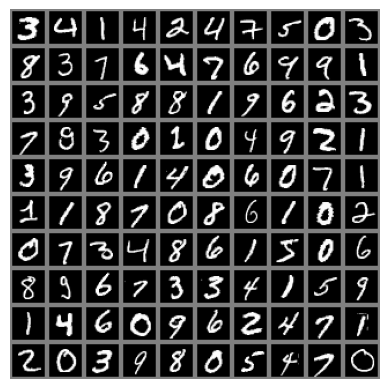

In [6]:
n_rimages = 10; n_cimages = 10 
padding = 2 
canvas = 0.5 * np.ones((n_rimages * (28 + 2 * padding), n_cimages * (28 + 2 * padding)))
rand_idxs = np.random.permutation(np.arange(len(train_X))[:n_rimages * n_cimages])
for r in range(n_rimages):
    for c in range(n_cimages):
        i = r * n_cimages + c
        image = train_X[rand_idxs[i]].reshape(28, 28)
        temp1 = r * (28 + 2 * padding) + padding 
        temp2 = c * (28 + 2 * padding) + padding 
        canvas[temp1:temp1 + 28, temp2:temp2 + 28] = image
plt.imshow(canvas, cmap='gray', vmin=0, vmax=1)
plt.axis('off');

In [7]:
values, counts = np.unique(train_y, return_counts=True)
for value, count in zip(values, counts):
    print(f'Value: {value}, count: {count}')

Value: 0, count: 4932
Value: 1, count: 5678
Value: 2, count: 4968
Value: 3, count: 5101
Value: 4, count: 4859
Value: 5, count: 4506
Value: 6, count: 4951
Value: 7, count: 5175
Value: 8, count: 4842
Value: 9, count: 4988


## **Preprocessing and function definition**

### *Preprocessing*

In [8]:
def add_ones(X):
    return np.hstack((np.ones((len(X), 1)), X))

train_Z = add_ones(train_X)
train_Z.shape

(50000, 785)

### *Training and support function definition*

In [9]:
def sigmoid(x):
    return 1/(1 + np.exp(-1.*x))


def softmax(X, return_prob=True):
    prob = np.exp(X)/np.sum(np.exp(X), axis=1, keepdims=True)
    if return_prob: return prob
    return np.argmax(prob, axis=1)


def compute_nnet_output(Ws, X, return_what='class'):
    X_in = X
    outs = []
    outs.append(X_in)

    # Hidden layers
    for i in range(len(Ws) - 1):
        X_in = X_in @ Ws[i]
        X_in = sigmoid(X_in)

        # Add bias for next layer
        X_in = add_ones(X_in)
        
        outs.append(X_in)

    # Output layer
    out = X_in @ Ws[-1]
    outs.append(softmax(out))

    if return_what == "all": return outs
    elif return_what == "prob":
        return softmax(out)
    elif return_what == "class":
        return softmax(out, return_prob=False)


def onehot(y, n_class=10):
    encoded = np.zeros((y.shape[0], n_class))
    encoded[np.arange(y.shape[0]), y] = 1
    return encoded


def train_nnet(X, y, 
               hid_layer_sizes, 
               initial_Ws, mb_size, lr, max_epoch):
    # Cách để khởi tạo tốt các trọng số khá là "bí hiểm"
    # nên mình sẽ làm cho bạn ;-)
    np.random.seed(0) # Cố định sự ngẫu nhiên để mình và bạn sẽ ra cùng kết quả
    n_classes = len(np.unique(y)) 
    if initial_Ws is None:
        layer_sizes = [X.shape[1] - 1] + hid_layer_sizes + [n_classes]
        Ws = [np.random.randn(layer_sizes[i] + 1, layer_sizes[i + 1]) 
              / np.sqrt(layer_sizes[i] + 1) 
              for i in range(len(layer_sizes) - 1)] 
    else:
        Ws = initial_Ws
    
    # Phần còn lại là của bạn
    
    # Keep dtype of target classes
    y_dtype = y.dtype

    # Combine X and y into a data matrix
    y = np.expand_dims(y, axis=1)
    data = np.concatenate([X, y], axis=1)

    sample_size = data.shape[0]
    n_batch = sample_size//mb_size

    # Cross-entropy Errors
    cees = []
    
    for _ in range(max_epoch):
        np.random.shuffle(data)
        X, y = data[:, :-1], data[:, -1].astype(y_dtype)

        # Stochastic gradient descent
        for i_batch in range(n_batch):
            batch_start = i_batch*mb_size
            X_batch = data[batch_start:batch_start + mb_size, :-1]
            y_batch = data[batch_start:batch_start + mb_size, -1].astype(y_dtype)

            # 1. Forward
            activations = compute_nnet_output(Ws, X_batch, return_what="all")
            
            # 2. Delta of final layer
            delta_out = activations[-1] - onehot(y_batch)

            # 3. Gradient of final output layer
            dOut = (activations[-2].T @ delta_out) / activations[-2].shape[0]

            # 4. Update output layer weights
            Ws[-1] -= lr*dOut

            # 5. Back propagate from last to first, skip final output layer
            delta_hidden = delta_out
            for l in range(len(Ws) - 2, -1, -1):

                # Get corresponding weights and outputs
                # NOTE: delta of layer l+1, weights of layer l+1, outputs of layer l
                W_after = Ws[l + 1]

                # Indexing is offsetted by 1 
                # because activations array contains initial input vector
                layer_inputs, layer_outputs = activations[l], activations[l + 1][:, 1:]

                # Sigmoid derivative
                dSigmoid = layer_outputs*(1 - layer_outputs)

                # 5.1. Delta of layer l
                delta_hidden = (delta_hidden @ (W_after.T[:, 1:]))*dSigmoid

                # 5.2 + 5.3. Gradient descent step
                dHidden = (layer_inputs.T @ delta_hidden)/layer_inputs.shape[0]
                Ws[l] -= lr*dHidden

        # Calculate cross-entropy error
        y_pred_prob = compute_nnet_output(Ws, X, return_what="prob")
        ce_error = -1.*np.sum(onehot(y)*np.log(y_pred_prob))/X.shape[0]
        cees.append(ce_error)
        
    
    return Ws, cees

CPU times: total: 8min 32s
Wall time: 1min 29s


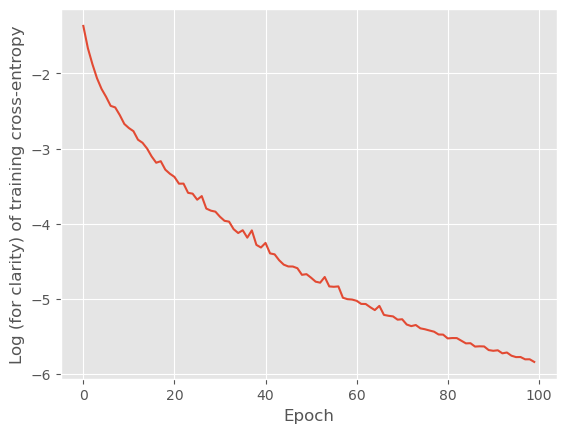

In [10]:
%%time
Ws_1, train_ces = train_nnet(
    train_Z, train_y,
    hid_layer_sizes=[50], 
    initial_Ws=None, mb_size=32, lr=0.3, max_epoch=100)
plt.plot(np.log(train_ces))
plt.xlabel('Epoch')
plt.ylabel('Log (for clarity) of training cross-entropy');

## **Model assessment**

In [11]:
def compute_mbe(predicted_y, y):
    return np.mean(predicted_y != y) * 100

In [12]:
predicted_train_y = compute_nnet_output(Ws_1, train_Z, return_what='class')
train_mbe = compute_mbe(predicted_train_y, train_y)
print(f"-- Mean Binary Error after training: {train_mbe}")

-- Mean Binary Error after training: 0.002


In [13]:
val_Z = add_ones(val_X)
predicted_val_y = compute_nnet_output(Ws_1, val_Z, return_what='class')
val_mbe = compute_mbe(predicted_val_y, val_y)
print(f"-- Mean Binary Error on validation set: {val_mbe}")

-- Mean Binary Error on validation set: 2.8899999999999997
